In [ ]:
!pip install qiskit
!pip install pylatexenc

In [2]:
import matplotlib.pyplot as plt

import numpy as np;

from qiskit import QuantumCircuit,QuantumRegister
from qiskit.circuit import Gate
from qiskit.circuit.library import StatePreparation
from qiskit.quantum_info import Statevector

from qiskit import Aer, execute
from qiskit.visualization import plot_histogram
backend = Aer.get_backend('qasm_simulator')

num_qubits = 3;
state_dim = 2**num_qubits

ampl_encode = np.zeros(state_dim)

print(ampl_encode)

[0. 0. 0. 0. 0. 0. 0. 0.]


In [3]:
for i in range(0,state_dim):
    ampl_encode[i]=np.sqrt(i+1)
#after squaring, this should produce probabilities that increase linearly with the index, see the plot below
print(ampl_encode)
ampl_encode /= np.linalg.norm(ampl_encode)
print(ampl_encode)

[1.         1.41421356 1.73205081 2.         2.23606798 2.44948974
 2.64575131 2.82842712]
[0.16666667 0.23570226 0.28867513 0.33333333 0.372678   0.40824829
 0.44095855 0.47140452]


In [4]:
ampl_encode2 = np.zeros(state_dim) # is the reverse, 0...0 -> should be decreasing
for i in range(0,state_dim):
    ampl_encode2[i]=np.sqrt(state_dim-i)
print(ampl_encode2)
ampl_encode2 /= np.linalg.norm(ampl_encode2)
print(ampl_encode2)

[2.82842712 2.64575131 2.44948974 2.23606798 2.         1.73205081
 1.41421356 1.        ]
[0.47140452 0.44095855 0.40824829 0.372678   0.33333333 0.28867513
 0.23570226 0.16666667]


In [5]:
def StatePrep(num_qubits,ampl_encode,gate_name): # prepping of the state
    qc = QuantumCircuit(num_qubits)
    sp = StatePreparation(ampl_encode)
    qc.append(sp, range(num_qubits))
    #reverse bits to make count plots easier to interpret
    ufg = qc.reverse_bits().to_gate();
    ufg.name = gate_name
    return ufg

In [6]:
qr = QuantumRegister(num_qubits+1, 'q')

qRAM=StatePrep(num_qubits,ampl_encode,' qRAM')
ctrlQRAM = qRAM.control(1, 'qRAM.control');
print(ctrlQRAM)
qRAM2=StatePrep(num_qubits,ampl_encode2,' qRAM2')
ctrlQRAM2 = qRAM2.control(1, 'qRAM2.control', 0); # apply control in an inverse fashion that does something when in state 0
print(ctrlQRAM2)

Instruction(name='c qRAM', num_qubits=4, num_clbits=0, params=[])
Instruction(name='c qRAM2_o0', num_qubits=4, num_clbits=0, params=[])


inner_product:  0.0124
prediction:  1.0


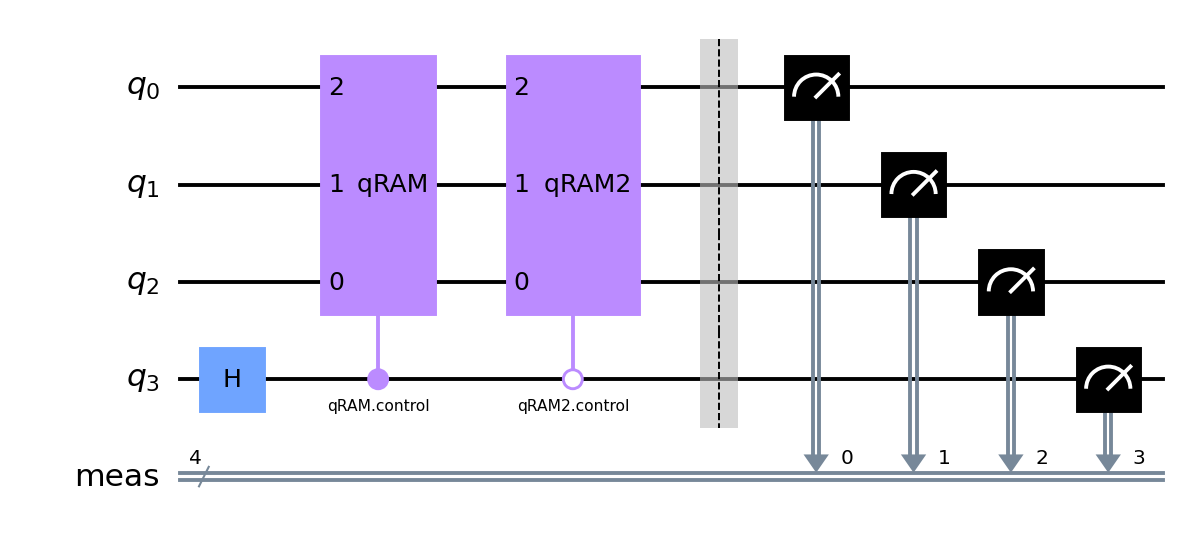

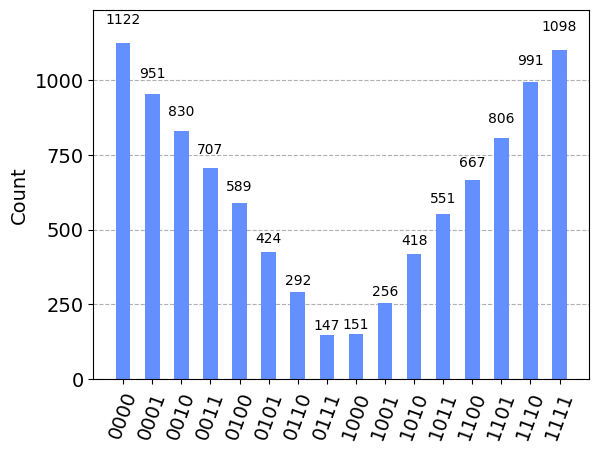

In [19]:
qc = QuantumCircuit(qr)
qc.h(0)


# this will load first vector (ampl_encode, via sub-circuit ctrlQRAM)
qc.append(ctrlQRAM, list(range(0,num_qubits+1)))

#TODO: add loading of the second vector (ampl_encode2, sub-circuit ctrlQRAM2) but controlled by |0>
#right now, nothing was loaded into the |0> part, 
#so its in |0>|000> state, we see huge peak (50% counts) on the plot below

#on the other had, for |1>, we loaded the vector ampl_encode, and we see nice linear growth of counts
#corresponding to linearly increasing values in vector ampl_encode

# need a control gate that operates ctrlQRAM2 when the |0>...

# ctrlQRAM2 = qRAM2.control(1, 'qRAM2.control',0);
qc.append(ctrlQRAM2, list(range(0,num_qubits+1)))

#reverse bits to make count plots easier to interpret
qc=qc.reverse_bits();

#TODO estimation of the inner product of the two vectors
#ypred= sign(〈w|x〉)
# Quantum Swap test
# qc.cswap(0, num_qubits - 1, num_qubits)


qc.measure_all()
job = execute(qc, backend=backend, shots=10000)

counts = job.result().get_counts()

count0 = 0
for key in counts:
  if key[0] == '0':
    count0 += counts[key]
count1 = 10000 - count0
# Estimating the inner product
inner_product = (count0 - count1)/10000
print('inner_product: ', inner_product)
#prediction
# ypred = np.arccos(inner_product) / np.pi
ypred = np.sign(inner_product)
print('prediction: ', ypred)
# Estimate inner product
# inner_product = (p0 - p1) * state_dim / 2


f, ax = plt.subplots(figsize=(15, 15))

qc.draw(output='mpl',ax=ax)

f2, ax2 = plt.subplots()
plot_histogram(counts,ax=ax2)